### Sentiment Mining and Trend Analysis of Amazon Food Products — Identifying Product Perception Patterns Over Time

In [2]:
# Loading the data 

import pandas as pd 

file_path = '/Users/viz/Documents/Projects/NLP Amazon fine food review /Amazon Fine Food Reviews/Reviews.csv'
df = pd.read_csv(file_path)

print("shape of the dataset:", df.shape)
print("First few rows:")
print(df.head())


shape of the dataset: (568454, 10)
First few rows:
   Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      5  1303862400   
1                     0                       0      1  1346976000   
2                     1                       1      4  1219017600   
3                     3                       3      2  1307923200   
4                     0                       0      5  1350777600   

                 Summary                                               Text  
0  Good Quality Dog Food  I h

### EDA & Cleaning

In [3]:
## Data Overview

print(df.columns)
print(df.dtypes)
print(df.head(3))

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')
Id                         int64
ProductId                 object
UserId                    object
ProfileName               object
HelpfulnessNumerator       int64
HelpfulnessDenominator     int64
Score                      int64
Time                       int64
Summary                   object
Text                      object
dtype: object
   Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      5  1303862400   
1                     0                       0      1  1346976000  

In [5]:
## converting unix timestamps to datetime

df['reviewTime'] = pd.to_datetime(df['Time'], unit='s')
print('Date range:', df['reviewTime'].min(), "to", df['reviewTime'].max())

Date range: 1999-10-08 00:00:00 to 2012-10-26 00:00:00


In [6]:
### Checking missing values

missing = df[['Score', 'Summary', 'Text', 'reviewTime']].isnull().sum()
print("Missing values:\n", missing)


Missing values:
 Score          0
Summary       27
Text           0
reviewTime     0
dtype: int64


In [7]:
df['Summary'] = df['Summary'].fillna('')

#Drop rows missing Text or Score (just in case)
before_drop = df.shape[0]
df = df.dropna(subset=['Text','Score'])
after_drop = df.shape[0]
print("Rows dropped (missing Text/Score):", before_drop - after_drop)

#Remove exact duplicates
before_dup = df.shape[0]
df = df.drop_duplicates(subset=['UserId','ProductId','Text'])
after_dup = df.shape[0]
print("Duplicates removed:", before_dup - after_dup)

#Rating distribution
rating_counts = df['Score'].value_counts().sort_index()
print("Rating distribution (1–5):\n", rating_counts)


Rows dropped (missing Text/Score): 0
Duplicates removed: 1309
Rating distribution (1–5):
 Score
1     51965
2     29753
3     42558
4     80550
5    362319
Name: count, dtype: int64


### Sentiment Scoring & Trend Analysis

In [9]:
import nltk 
nltk.download('vader_lexicon')

from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/viz/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [12]:
### Computing Sentiment Scores

df['sentiment_score'] = df['Text'].apply(lambda x: sid.polarity_scores(x)['compound'])

print(df[['Score','Text','sentiment_score']].head())

   Score                                               Text  sentiment_score
0      5  I have bought several of the Vitality canned d...           0.9441
1      1  Product arrived labeled as Jumbo Salted Peanut...          -0.5664
2      4  This is a confection that has been around a fe...           0.8265
3      2  If you are looking for the secret ingredient i...           0.0000
4      5  Great taffy at a great price.  There was a wid...           0.9468


In [13]:
### validating Sentiment vs Star Rating

avg_by_rating = df.groupby('Score')['sentiment_score'].mean().sort_index()
print("Average sentiment by star rating:\n", avg_by_rating)

Average sentiment by star rating:
 Score
1    0.035210
2    0.272187
3    0.482950
4    0.704553
5    0.772384
Name: sentiment_score, dtype: float64


### Trend Visualization & Outlier Detection

In [14]:
import matplotlib.pyplot as plt 

Matplotlib is building the font cache; this may take a moment.


/var/folders/79/6646lb6j6lq8cybcqz7_wj200000gn/T/ipykernel_13717/667513881.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .groupby(pd.Grouper(key='reviewTime', freq='M'))['sentiment_score']


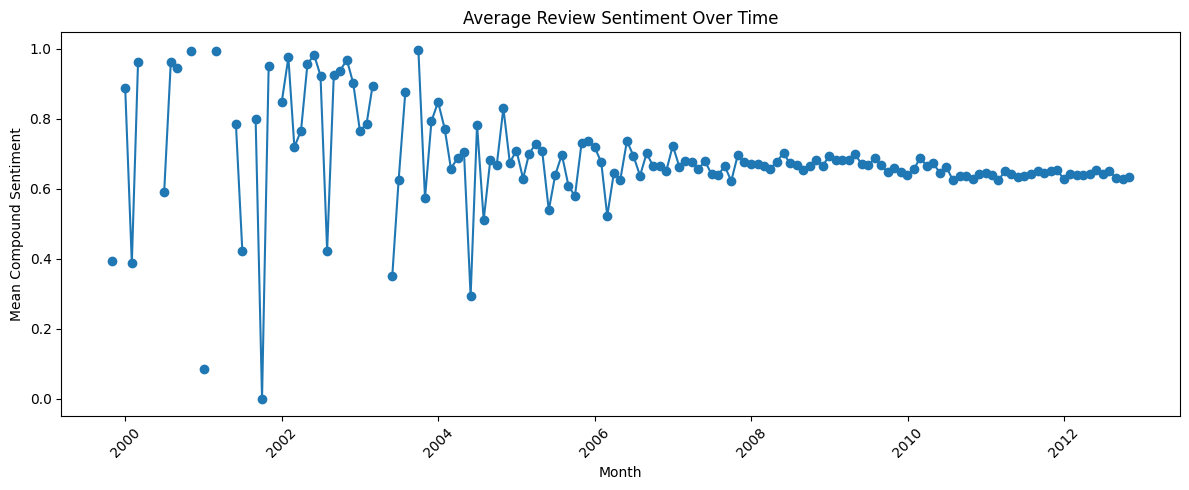

In [17]:
### Plotting Monthly Average Sentiment 
# Group by month directly
monthly_sentiment = (
    df
    .groupby(pd.Grouper(key='reviewTime', freq='M'))['sentiment_score']
    .mean()
)

# Plot
plt.figure(figsize=(12,5))
plt.plot(monthly_sentiment.index, monthly_sentiment.values, marker='o')
plt.title("Average Review Sentiment Over Time")
plt.xlabel("Month")
plt.ylabel("Mean Compound Sentiment")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



In [18]:
# Month-over-month changes
monthly_diff = monthly_sentiment.diff()

# Top 5 spikes & dips
print("Spikes:\n", monthly_diff.nlargest(5))
print("Dips:\n", monthly_diff.nsmallest(5))


Spikes:
 reviewTime
2001-10-31    0.951067
2000-02-29    0.574888
2002-08-31    0.501650
2004-06-30    0.490307
2000-07-31    0.371420
Name: sentiment_score, dtype: float64
Dips:
 reviewTime
2001-09-30   -0.800000
2002-07-31   -0.500750
2000-01-31   -0.500437
2003-10-31   -0.424482
2004-05-31   -0.412631
Name: sentiment_score, dtype: float64


In [27]:
### Checking monthly review counts to confirm the initial noise in spikes and dips

# Print the counts for September, October 2001 and July 2002
print("2001-09 count:", monthly_counts['2001-09'])
print("2001-10 count:", monthly_counts['2001-10'])
print("2002-07 count:", monthly_counts['2002-07'])


2001-09 count: reviewTime
2001-09-30    3
Freq: ME, Name: sentiment_score, dtype: int64
2001-10 count: reviewTime
2001-10-31    3
Freq: ME, Name: sentiment_score, dtype: int64
2002-07 count: reviewTime
2002-07-31    4
Freq: ME, Name: sentiment_score, dtype: int64


In [28]:
# Turn the DatetimeIndex into a PeriodIndex (year-month)
monthly_counts_period = monthly_counts.copy()
monthly_counts_period.index = monthly_counts_period.index.to_period('M')

# Now you can .loc a list of period strings
print(monthly_counts_period.loc[['2001-09', '2001-10', '2002-07']])


reviewTime
2001-09    3
2001-10    3
2002-07    4
Freq: M, Name: sentiment_score, dtype: int64
